In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FactorAnalysis
from sklearn import preprocessing
import glob
from sncosmo.salt2utils import BicubicInterpolator
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
import sncosmo
from scipy.interpolate import interp1d, interp2d
from numpy import random
import pickle as pk
from astropy.table import Table
from sncosmo.constants import HC_ERG_AA
from factor_analyzer import FactorAnalyzer
import statsmodels
from statsmodels.multivariate.factor import Factor
from statsmodels.multivariate.factor import FactorResults

SCALE_FACTOR = 1e-12

sns.set_style("whitegrid", {'axes.grid':'False','xtick.bottom': True,'ytick.left': True})

params = {"text.usetex" : True,'font.size': 20, 'font.family':'serif', 'font.serif':'Computer Modern'}
plt.rcParams.update(params)

In [2]:
class ScalarFormatterClass1(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"

In [3]:
p_grid=np.arange(-10,51,1)
w_grid1=np.arange(3350,8710,10)
w_grid2=np.arange(3400,8410,10)

In [4]:
fname=[]
for file in glob.glob("./final_SEDs/*.dat"):
    fname.append(file.split("/")[2].split(".")[0])

In [5]:
exclude=["Train_SN93_SED","Test_SN15_SED","Test_SN26_SED","Train_SN30_SED","Train_SN96_SED"]

In [6]:
data=[]
sne_names=[]
for sn in fname:
    if sn not in exclude:
        data.append(pd.read_csv(f"./final_SEDs/{sn}.dat")["flux"].values)
        sne_names.append(sn)

In [7]:
len(data)

164

## Applying FA

In [8]:
train_data, test_data, train_names, test_names=train_test_split(data,sne_names,test_size=0.1,random_state=0)

### Factor Analyzer

In [9]:
Means=np.mean(train_data,axis=1)

In [10]:
Means.shape

(147,)

In [11]:
mean_cor_data=[train_data[i]-Means[i] for i in range(len(train_data))]

In [12]:
training_data=np.array(mean_cor_data).T

In [13]:
np.mean(train_data[0])

0.06598197666597747

In [14]:
np.std(train_data[0])

0.0707685317487314

In [15]:
# Rotations avaiable:
# varimax (orthogonal rotation)
# promax (oblique rotation) O unico que ficou ruim
# oblimin (oblique rotation)
# oblimax (orthogonal rotation)
# quartimin (oblique rotation)
# quartimax (orthogonal rotation)
# equamax (orthogonal rotation)

In [16]:
fa_no_rot = FactorAnalyzer(3,rotation=None)#,method="ml")
factors_no_rot = fa_no_rot.fit_transform(training_data)
fa_no_rot.get_factor_variance()[2]

array([0.93770654, 0.96259471, 0.97149949])

In [17]:
factors_no_rot.shape

(30561, 3)

In [17]:
fa_varimax = FactorAnalyzer(3,rotation="varimax")#,method="ml")
factors_varimax = fa_varimax.fit_transform(training_data)
fa_varimax.get_factor_variance()[2]

array([0.53707536, 0.79839397, 0.97149949])

In [18]:
fa_quartimax = FactorAnalyzer(3,rotation="quartimax")#,method="ml")
factors_quartimax = fa_quartimax.fit_transform(training_data)
fa_quartimax.get_factor_variance()[2]

array([0.93745052, 0.96229982, 0.97149949])

In [19]:
# The cumulative explained variances are more similar to the analogous
# using sklearn with previous scaling. Indicating the Factor Analyzer
# performs such process internally. For the comparison with sklearn we
# use method="ml" but every time this returns a convergence warning.

In [20]:
for i in range(3):
    print(np.mean(factors_no_rot[:,i]))
    print(np.mean(factors_varimax[:,i]))
    print(np.mean(factors_quartimax[:,i]))

5.207996230825642e-16
3.4372775123449235e-15
6.844795046227987e-16
-6.7778350946888e-15
-5.896195732756173e-15
-7.0605548900764775e-15
-2.3733582823333996e-15
2.351038298487004e-15
-1.4433589554002493e-15


In [21]:
for i in range(3):
    print(np.std(factors_no_rot[:,i]))
    print(np.std(factors_varimax[:,i]))
    print(np.std(factors_quartimax[:,i]))

1.0000632575519144
1.0034601333911102
1.0000577374318136
1.0061320975443424
1.0054567669349634
1.0064320781407328
1.0143478485165025
1.01165919415768
1.0140556535498777


In [22]:
# The common factor are returned with zero mean and unit variance even though
# no such scaling was applied to the training data.

In [23]:
fa_promax = FactorAnalyzer(3,rotation="promax")
factors_promax = fa_promax.fit_transform(training_data)
print(fa_promax.get_factor_variance()[2])
print(fa_promax.phi_)

[0.44038636 0.53195553 0.61539349]
[[1.         0.74818035 0.82163599]
 [0.74818035 1.         0.73393373]
 [0.82163599 0.73393373 1.        ]]


In [24]:
fa_oblimin = FactorAnalyzer(3,rotation="oblimin")
factors_oblimin = fa_oblimin.fit_transform(training_data)
print(fa_oblimin.get_factor_variance()[2])
print(fa_oblimin.phi_)

[0.90202458 0.9326323  0.94288871]
[[1.         0.44373699 0.04418806]
 [0.44373699 1.         0.16525476]
 [0.04418806 0.16525476 1.        ]]


In [25]:
fa_oblimax = FactorAnalyzer(3,rotation="oblimax")
factors_oblimax = fa_oblimax.fit_transform(training_data)
fa_oblimax.get_factor_variance()[2]

array([0.89279176, 0.96178861, 0.97149949])

In [26]:
fa_quartimin = FactorAnalyzer(3,rotation="quartimin")
factors_quartimin = fa_quartimin.fit_transform(training_data)
print(fa_quartimin.get_factor_variance()[2])
print(fa_quartimin.phi_)

[0.90202458 0.9326323  0.94288871]
[[1.         0.44373699 0.04418806]
 [0.44373699 1.         0.16525476]
 [0.04418806 0.16525476 1.        ]]


In [27]:
fa_equamax = FactorAnalyzer(3,rotation="equamax")
factors_equamax = fa_equamax.fit_transform(training_data)
fa_equamax.get_factor_variance()[2]

array([0.93745052, 0.96229982, 0.97149949])

In [28]:
Mean_transformed_no_rot=fa_no_rot.transform(Means.reshape(1, -1))
Mean_transformed_varimax=fa_varimax.transform(Means.reshape(1, -1))
Mean_transformed_promax=fa_promax.transform(Means.reshape(1, -1))
Mean_transformed_oblimin=fa_oblimin.transform(Means.reshape(1, -1))
Mean_transformed_oblimax=fa_oblimax.transform(Means.reshape(1, -1))
Mean_transformed_quartimin=fa_quartimin.transform(Means.reshape(1, -1))
Mean_transformed_quartimax=fa_quartimax.transform(Means.reshape(1, -1))
Mean_transformed_equamax=fa_equamax.transform(Means.reshape(1, -1))

In [29]:
fa_no_rot.transform(Means.reshape(1, -1))

array([[ 0.95531179,  0.42754198, -0.56456456]])

In [30]:
fa_no_rot.loadings_.shape

(147, 3)

In [31]:
np.dot(Means,fa_no_rot.loadings_.T[0]) # Também não funciona como projeção na primeira componente

8.734590402125926

In [32]:
X, Y=np.meshgrid(p_grid,w_grid2)

In [33]:
M_3_no_rot=[]
for i in range(3):
    sup_no_rot=factors_no_rot[::,i]+Mean_transformed_no_rot[0][i]
    M_3_no_rot.append(sup_no_rot.reshape(X.shape))

In [34]:
M_3_varimax=[]
for i in range(3):
    sup_varimax=factors_varimax[::,i]+Mean_transformed_varimax[0][i]
    M_3_varimax.append(sup_varimax.reshape(X.shape))

In [35]:
M_3_quartimax=[]
for i in range(3):
    sup_quartimax=factors_quartimax[::,i]+Mean_transformed_quartimax[0][i]
    M_3_quartimax.append(sup_quartimax.reshape(X.shape))

In [36]:
M_3_promax=[]
for i in range(3):
    sup_promax=factors_promax[::,i]+Mean_transformed_promax[0][i]
    M_3_promax.append(sup_promax.reshape(X.shape))

In [37]:
M_3_oblimin=[]
for i in range(3):
    sup_oblimin=factors_oblimin[::,i]+Mean_transformed_oblimin[0][i]
    M_3_oblimin.append(sup_oblimin.reshape(X.shape))

In [38]:
M_3_oblimax=[]
for i in range(3):
    sup_oblimax=factors_oblimax[::,i]+Mean_transformed_oblimax[0][i]
    M_3_oblimax.append(sup_oblimax.reshape(X.shape))

In [39]:
M_3_quartimin=[]
for i in range(3):
    sup_quartimin=factors_quartimin[::,i]+Mean_transformed_quartimin[0][i]
    M_3_quartimin.append(sup_quartimin.reshape(X.shape))

In [40]:
M_3_equamax=[]
for i in range(3):
    sup_equamax=factors_equamax[::,i]+Mean_transformed_equamax[0][i]
    M_3_equamax.append(sup_equamax.reshape(X.shape))

In [41]:
np.savetxt("./fa/fanz_no_rot_M0.txt",M_3_no_rot[0])
np.savetxt("./fa/fanz_no_rot_M1.txt",M_3_no_rot[1])
np.savetxt("./fa/fanz_no_rot_M2.txt",M_3_no_rot[2])

In [42]:
np.savetxt("./fa/fanz_varimax_M0.txt",M_3_varimax[0])
np.savetxt("./fa/fanz_varimax_M1.txt",M_3_varimax[1])
np.savetxt("./fa/fanz_varimax_M2.txt",M_3_varimax[2])

In [43]:
np.savetxt("./fa/fanz_quartimax_M0.txt",M_3_quartimax[0])
np.savetxt("./fa/fanz_quartimax_M1.txt",M_3_quartimax[1])
np.savetxt("./fa/fanz_quartimax_M2.txt",M_3_quartimax[2])

In [44]:
np.savetxt("./fa/fanz_promax_M0.txt",M_3_promax[0])
np.savetxt("./fa/fanz_promax_M1.txt",M_3_promax[1])
np.savetxt("./fa/fanz_promax_M2.txt",M_3_promax[2])

In [45]:
np.savetxt("./fa/fanz_oblimin_M0.txt",M_3_oblimin[0])
np.savetxt("./fa/fanz_oblimin_M1.txt",M_3_oblimin[1])
np.savetxt("./fa/fanz_oblimin_M2.txt",M_3_oblimin[2])

In [46]:
np.savetxt("./fa/fanz_oblimax_M0.txt",M_3_oblimax[0])
np.savetxt("./fa/fanz_oblimax_M1.txt",M_3_oblimax[1])
np.savetxt("./fa/fanz_oblimax_M2.txt",M_3_oblimax[2])

In [47]:
np.savetxt("./fa/fanz_quartimin_M0.txt",M_3_quartimin[0])
np.savetxt("./fa/fanz_quartimin_M1.txt",M_3_quartimin[1])
np.savetxt("./fa/fanz_quartimin_M2.txt",M_3_quartimin[2])

In [48]:
np.savetxt("./fa/fanz_equamax_M0.txt",M_3_equamax[0])
np.savetxt("./fa/fanz_equamax_M1.txt",M_3_equamax[1])
np.savetxt("./fa/fanz_equamax_M2.txt",M_3_equamax[2])

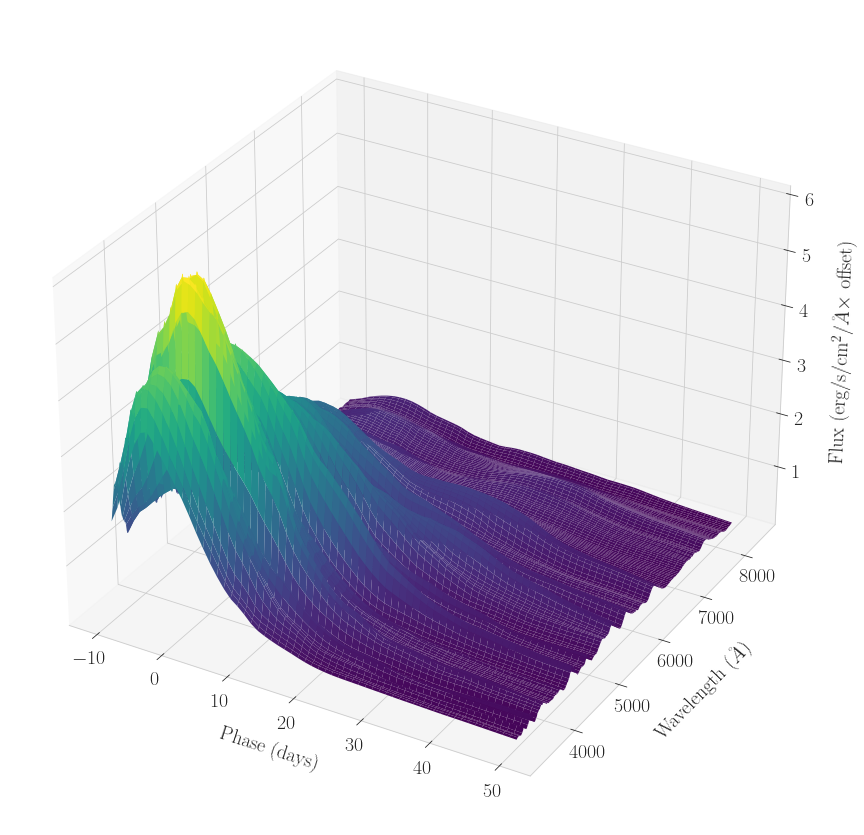

In [49]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_no_rot[0],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.show()

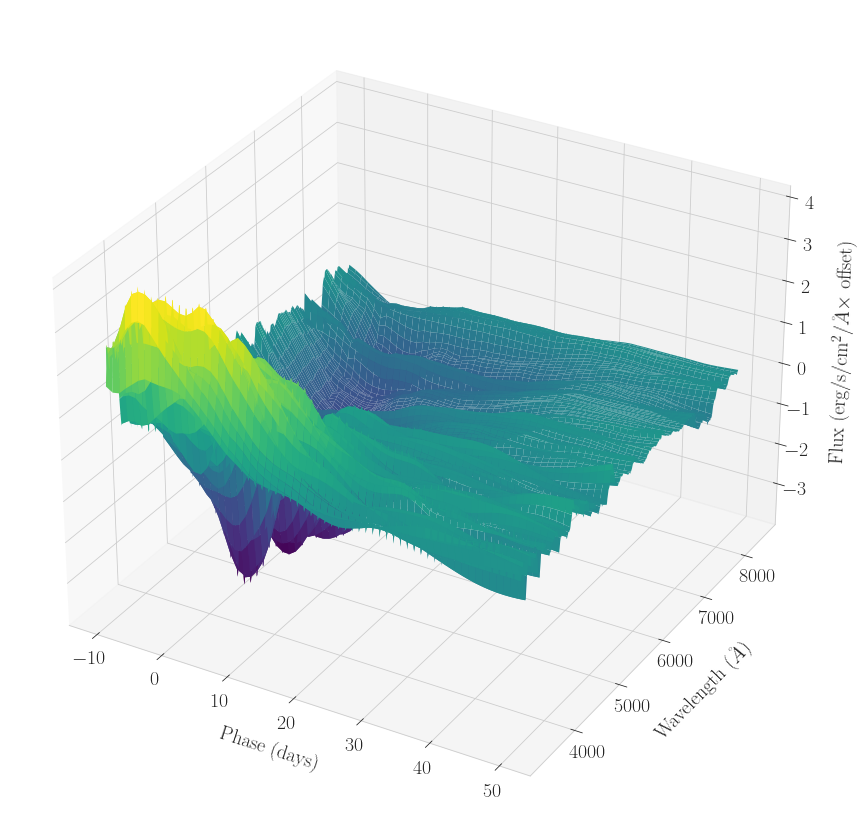

In [50]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,-M_3_no_rot[1],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.show()

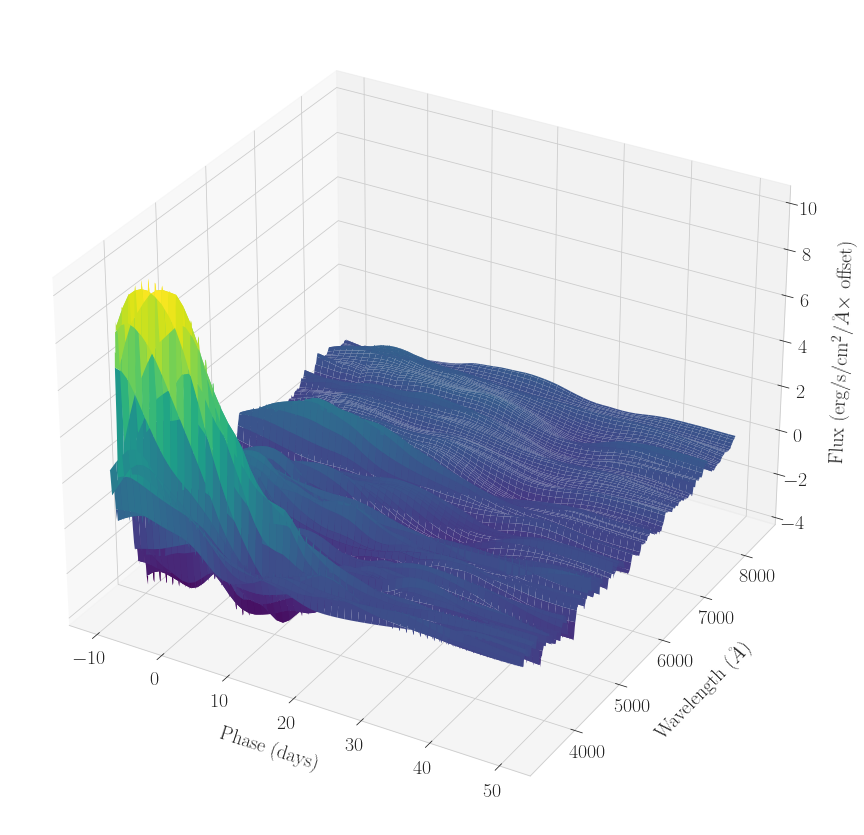

In [51]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_no_rot[2],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.show()

In [52]:
# The results for the no rotation case is quite similar the sk learn
# with and without scaling. All surfaces are similar and also the scales

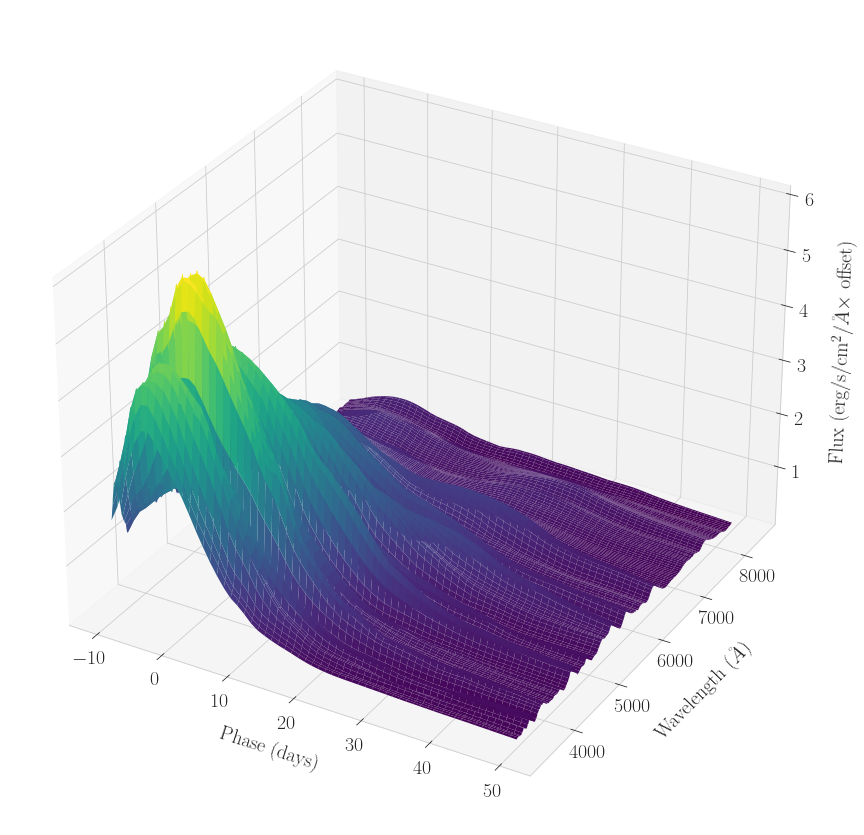

In [53]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_quartimax[0],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.show()

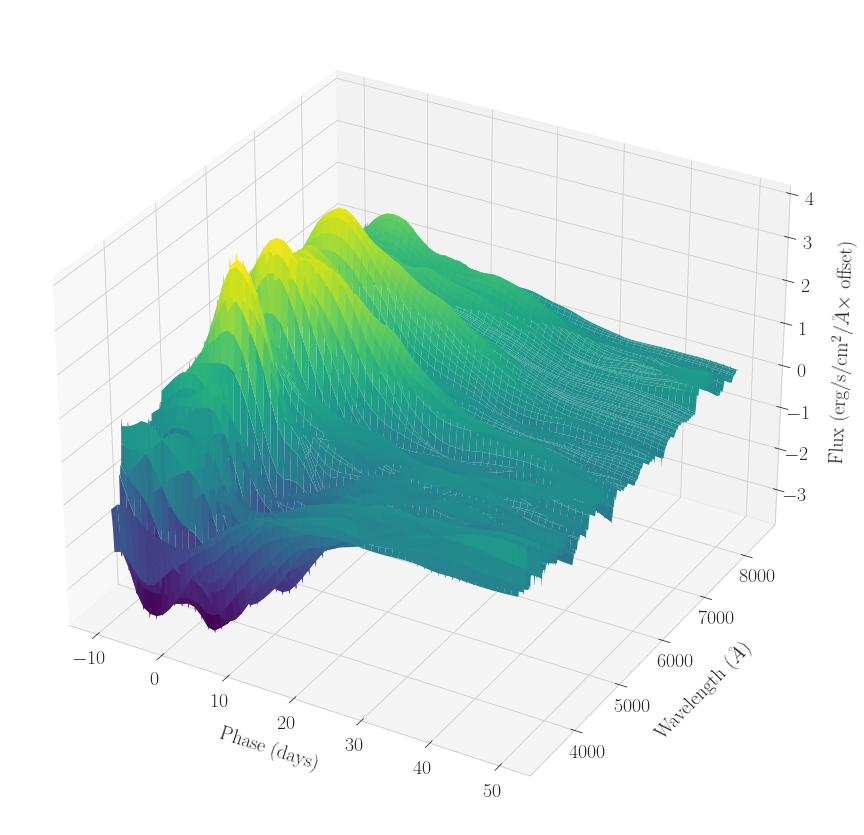

In [54]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_quartimax[1],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.show()

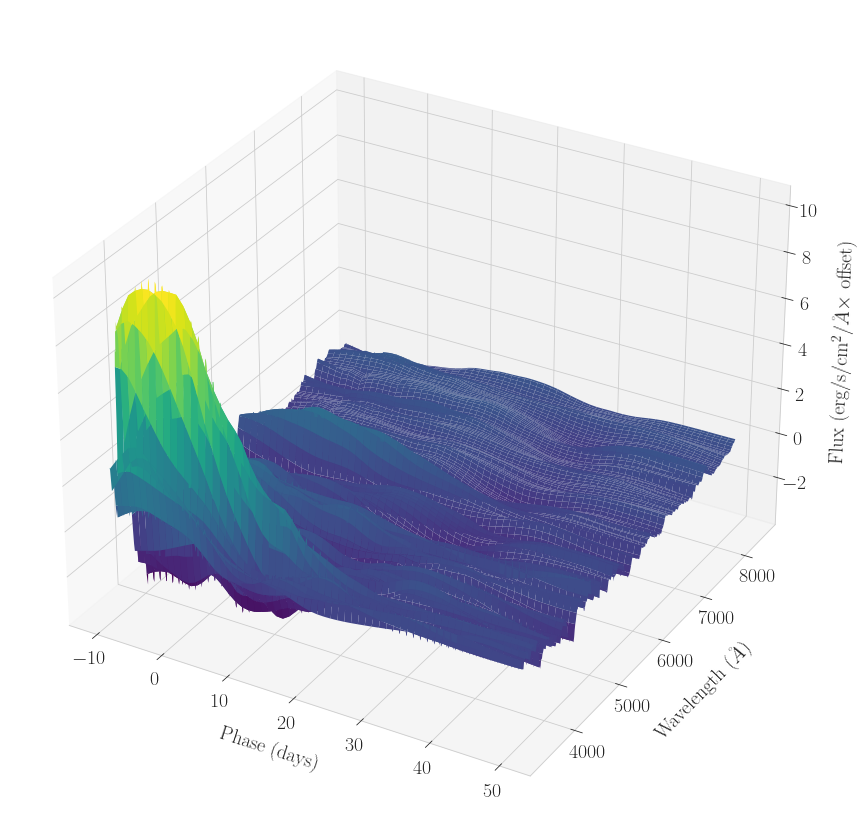

In [55]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_quartimax[2],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.show()

In [56]:
# The quartimax results are a lot similar to the sk learn FA with
# previous scaling. The scales are the same. And their surfaces are
# distinguisable from the only centering case. The second surface found
# is minus the one found from sklean with scaling.

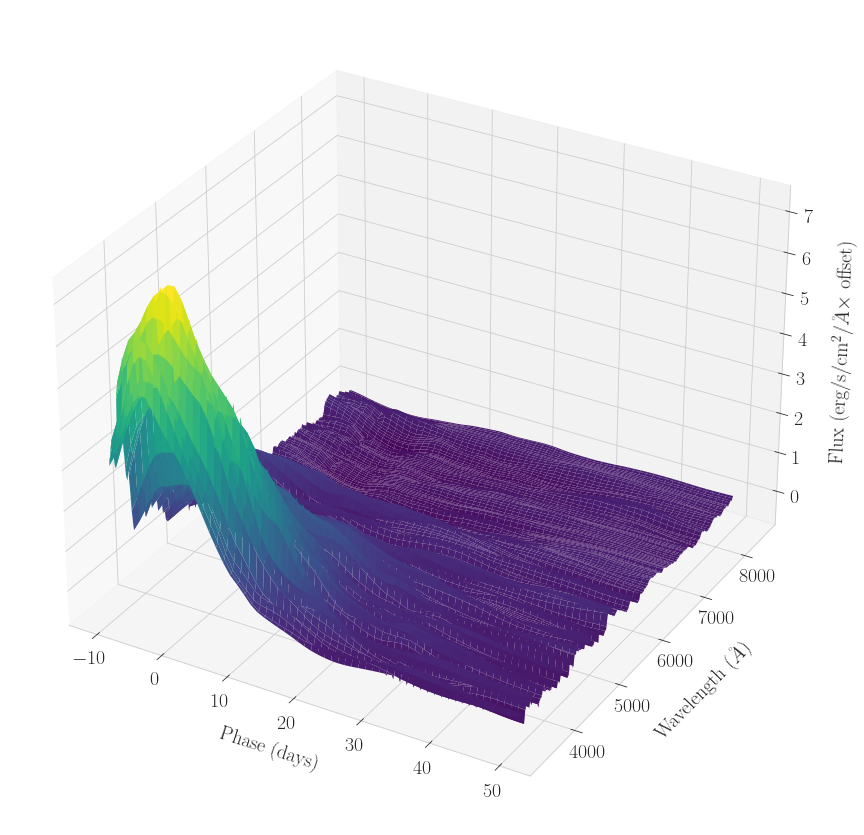

In [57]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_varimax[0],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.show()

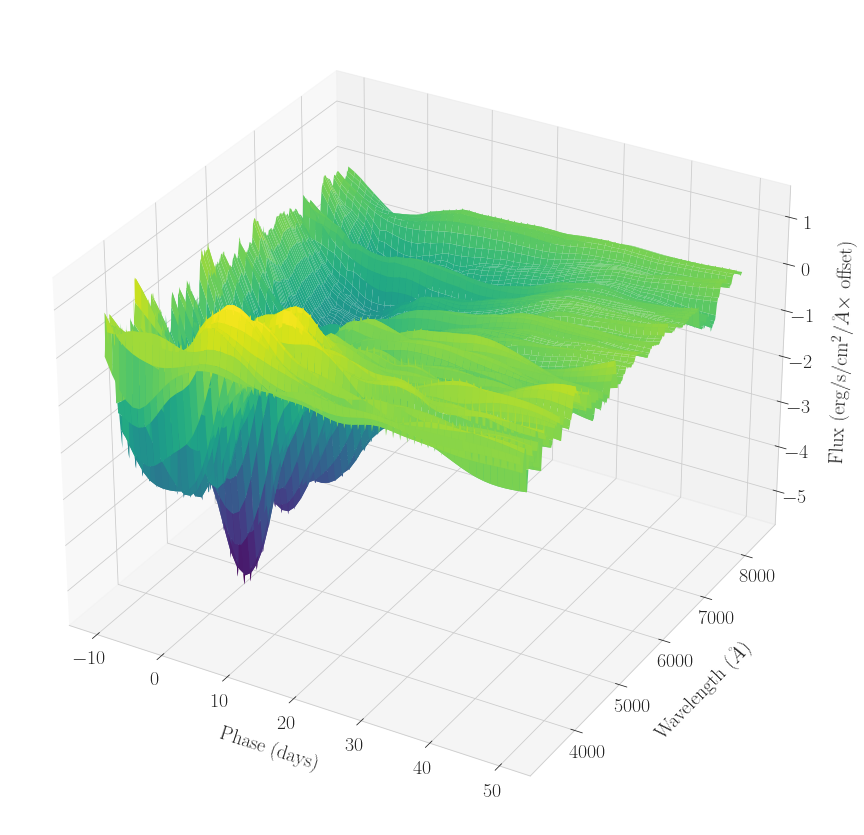

In [58]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,-M_3_varimax[1],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.show()

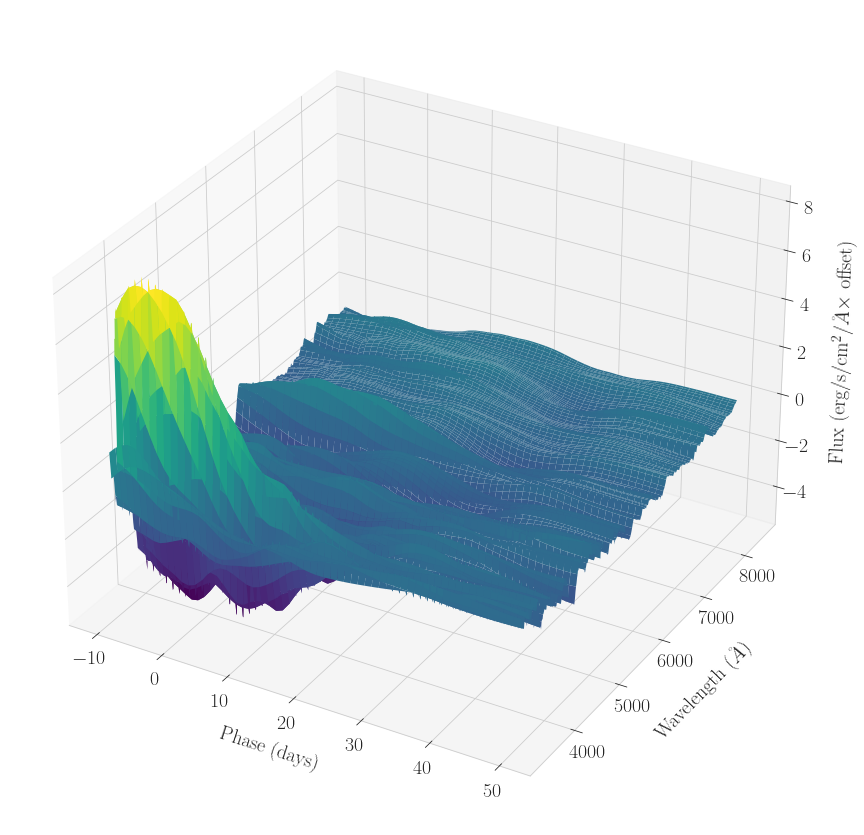

In [59]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,-M_3_varimax[2],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.show()

In [60]:
# As previously, this surfaces match the sklearn with previous scaling.
# With the same scales. This both methods differ from sklearn with
# only centering. The last one showing somehow similar surfaces with order
# exchanged and different scales.

In [61]:
# All this analysis indicates the Factor Analyzer performs internally 
# input data scaling (by centering and variance). 
# While sklearn does not. The main difference is regarding the variance
# scaling, that when applied assumes the same weigth for every supernova.
# As the main variability is explained by the first surface
# this change affect most the remaining surfaces than the first.
# This difference some how makes this apparent exchange in the two 
# last surfaces.

## Surface plots

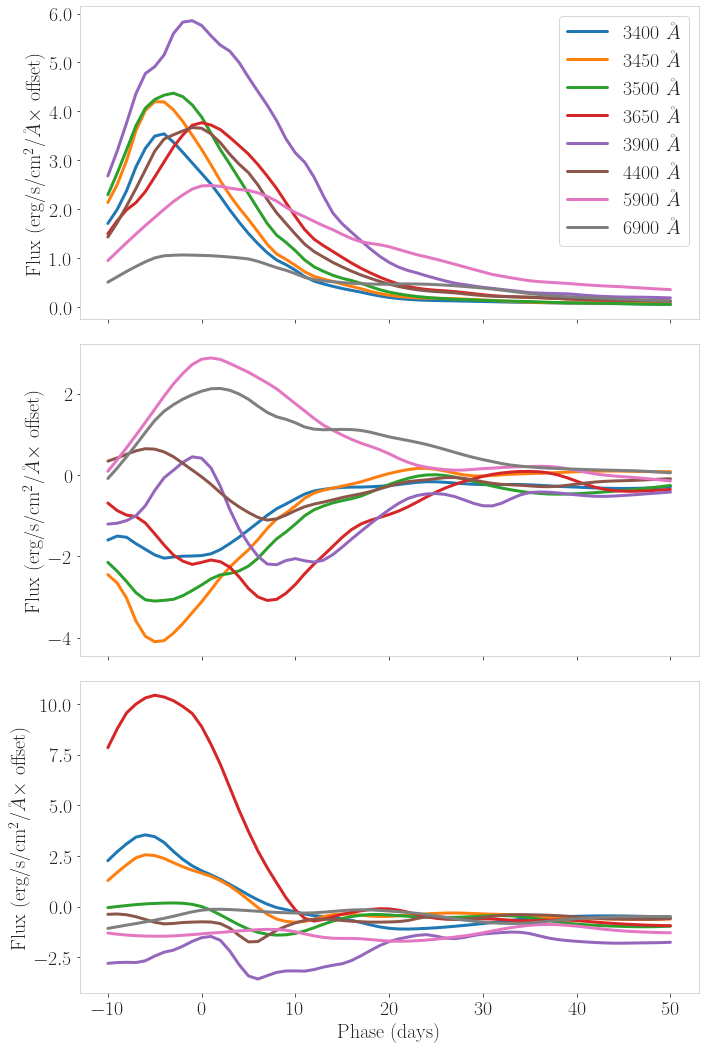

In [62]:
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)

colors=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f"]#"#fde725","#a0da39","#4ac16d","#1fa187","#277f8e","#365c8d","#46327e","#440154"]
for j,i in enumerate([0,5,10,25,50,100,250,350]):#
    axs[0].plot(X[i],M_3_no_rot[0][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax1.set_xlabel("Phase (days)")
    axs[0].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend()
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[1].plot(X[i],M_3_no_rot[1][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax2.set_xlabel("Phase (days)")
    axs[1].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[1].yaxis.set_major_formatter(formatter11)
    #axs[1].legend(loc=1)
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[2].plot(X[i],M_3_no_rot[2][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    axs[2].set_xlabel("Phase (days)")
    axs[2].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax3.set_title("Third Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[2].yaxis.set_major_formatter(formatter11)
    #axs[2].legend(loc=1)

#plt.show()
fig.tight_layout()
plt.savefig('./fa/fanz_FA_components_no_rot.pdf')  

# First, Second and Third Principal Components

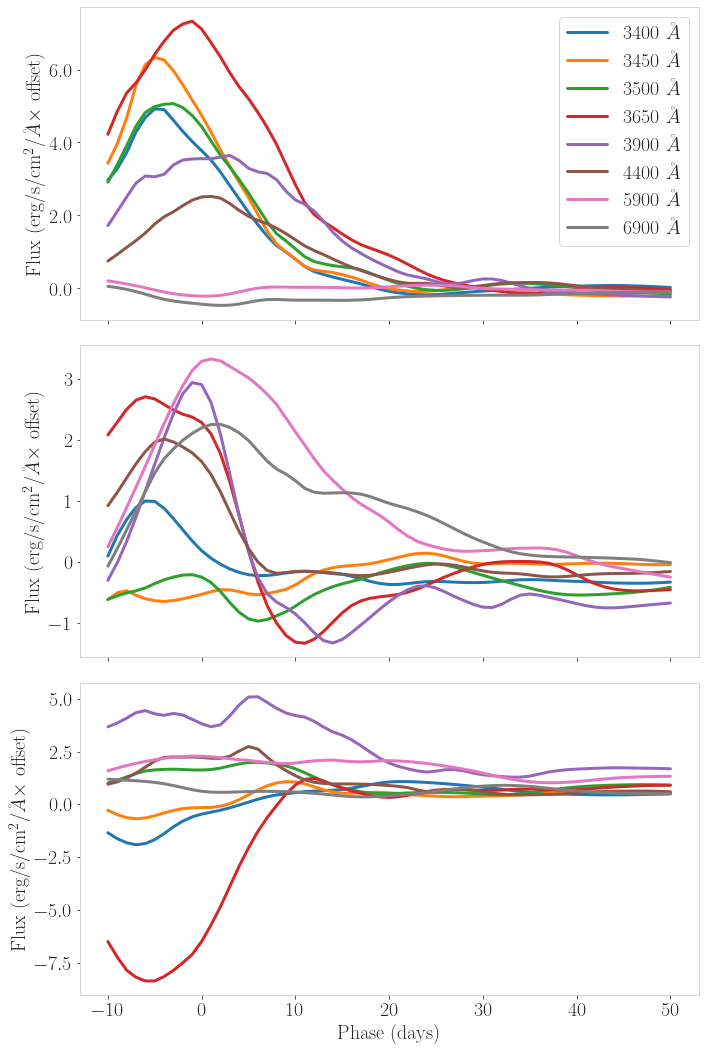

In [63]:
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)

colors=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f"]#"#fde725","#a0da39","#4ac16d","#1fa187","#277f8e","#365c8d","#46327e","#440154"]
for j,i in enumerate([0,5,10,25,50,100,250,350]):#
    axs[0].plot(X[i],M_3_varimax[0][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax1.set_xlabel("Phase (days)")
    axs[0].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend()
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[1].plot(X[i],M_3_varimax[1][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax2.set_xlabel("Phase (days)")
    axs[1].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[1].yaxis.set_major_formatter(formatter11)
    #axs[1].legend(loc=1)
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[2].plot(X[i],M_3_varimax[2][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    axs[2].set_xlabel("Phase (days)")
    axs[2].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax3.set_title("Third Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[2].yaxis.set_major_formatter(formatter11)
    #axs[2].legend(loc=1)

#plt.show()
fig.tight_layout()
plt.savefig('./fa/fanz_FA_components_varimax.pdf')  

# First, Second and Third Principal Components

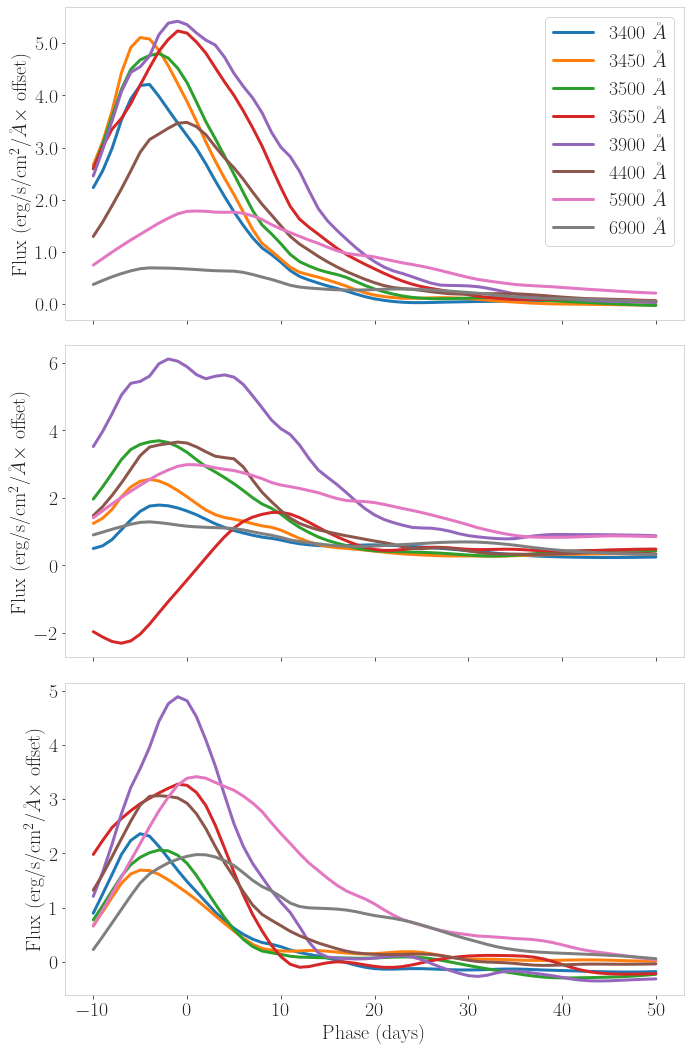

In [64]:
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)

colors=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f"]#"#fde725","#a0da39","#4ac16d","#1fa187","#277f8e","#365c8d","#46327e","#440154"]
for j,i in enumerate([0,5,10,25,50,100,250,350]):#
    axs[0].plot(X[i],M_3_promax[0][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax1.set_xlabel("Phase (days)")
    axs[0].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend()
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[1].plot(X[i],M_3_promax[1][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax2.set_xlabel("Phase (days)")
    axs[1].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[1].yaxis.set_major_formatter(formatter11)
    #axs[1].legend(loc=1)
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[2].plot(X[i],M_3_promax[2][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    axs[2].set_xlabel("Phase (days)")
    axs[2].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax3.set_title("Third Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[2].yaxis.set_major_formatter(formatter11)
    #axs[2].legend(loc=1)

#plt.show()
fig.tight_layout()
plt.savefig('./fa/fanz_FA_components_promax.pdf')  

# First, Second and Third Principal Components

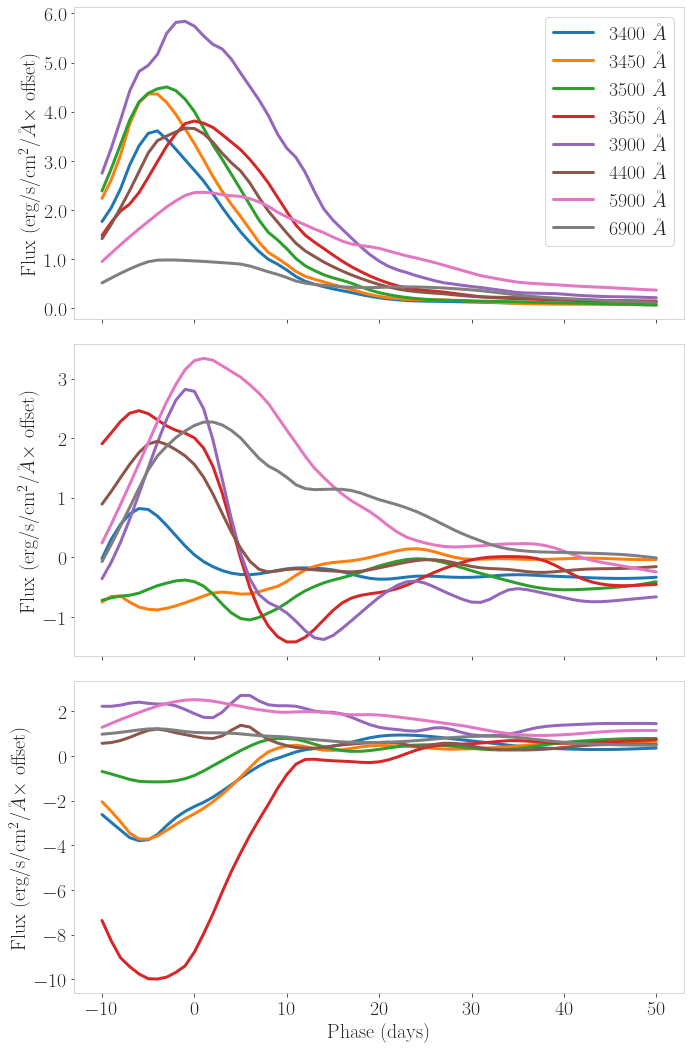

In [65]:
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)

colors=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f"]#"#fde725","#a0da39","#4ac16d","#1fa187","#277f8e","#365c8d","#46327e","#440154"]
for j,i in enumerate([0,5,10,25,50,100,250,350]):#
    axs[0].plot(X[i],M_3_oblimin[0][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax1.set_xlabel("Phase (days)")
    axs[0].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend()
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[1].plot(X[i],M_3_oblimin[1][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax2.set_xlabel("Phase (days)")
    axs[1].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[1].yaxis.set_major_formatter(formatter11)
    #axs[1].legend(loc=1)
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[2].plot(X[i],M_3_oblimin[2][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    axs[2].set_xlabel("Phase (days)")
    axs[2].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax3.set_title("Third Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[2].yaxis.set_major_formatter(formatter11)
    #axs[2].legend(loc=1)

#plt.show()
fig.tight_layout()
plt.savefig('./fa/fanz_FA_components_oblimin.pdf')  

# First, Second and Third Principal Components

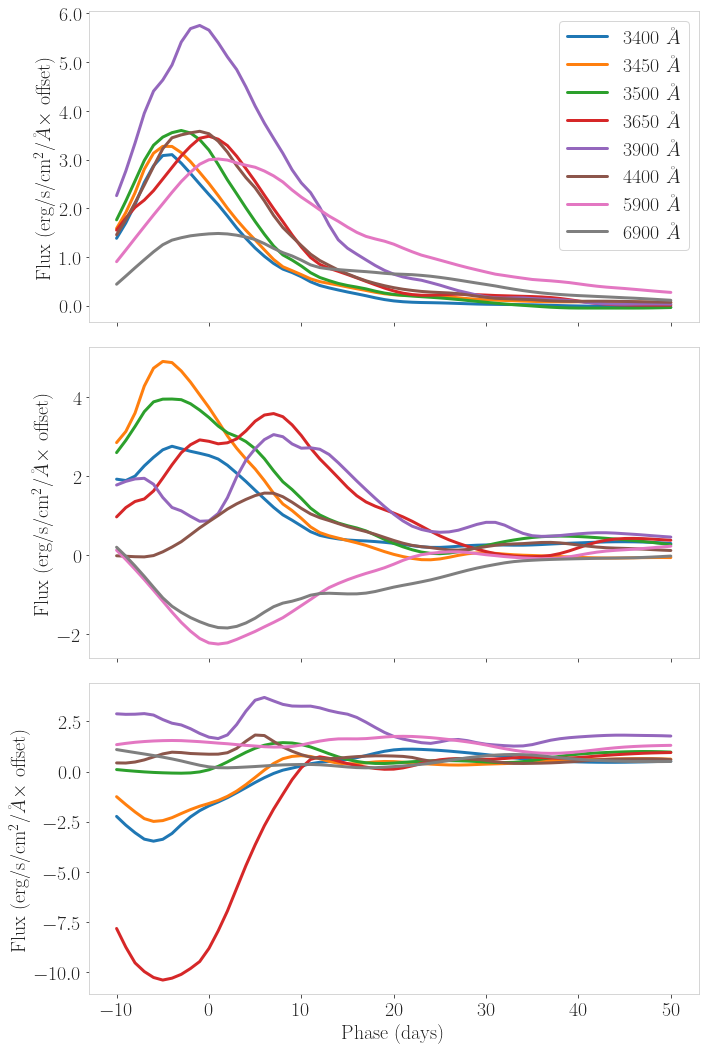

In [66]:
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)

colors=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f"]#"#fde725","#a0da39","#4ac16d","#1fa187","#277f8e","#365c8d","#46327e","#440154"]
for j,i in enumerate([0,5,10,25,50,100,250,350]):#
    axs[0].plot(X[i],M_3_oblimax[0][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax1.set_xlabel("Phase (days)")
    axs[0].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend()
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[1].plot(X[i],M_3_oblimax[1][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax2.set_xlabel("Phase (days)")
    axs[1].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[1].yaxis.set_major_formatter(formatter11)
    #axs[1].legend(loc=1)
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[2].plot(X[i],M_3_oblimax[2][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    axs[2].set_xlabel("Phase (days)")
    axs[2].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax3.set_title("Third Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[2].yaxis.set_major_formatter(formatter11)
    #axs[2].legend(loc=1)

#plt.show()
fig.tight_layout()
plt.savefig('./fa/fanz_FA_components_oblimax.pdf')  

# First, Second and Third Principal Components

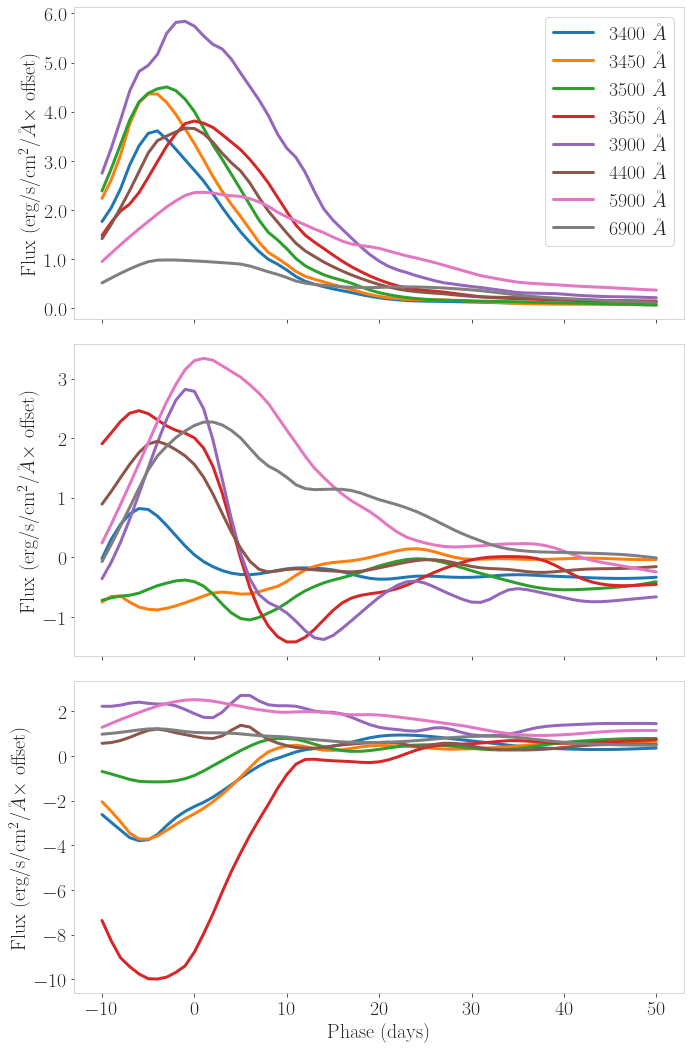

In [67]:
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)

colors=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f"]#"#fde725","#a0da39","#4ac16d","#1fa187","#277f8e","#365c8d","#46327e","#440154"]
for j,i in enumerate([0,5,10,25,50,100,250,350]):#
    axs[0].plot(X[i],M_3_quartimin[0][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax1.set_xlabel("Phase (days)")
    axs[0].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend()
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[1].plot(X[i],M_3_quartimin[1][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax2.set_xlabel("Phase (days)")
    axs[1].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[1].yaxis.set_major_formatter(formatter11)
    #axs[1].legend(loc=1)
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[2].plot(X[i],M_3_quartimin[2][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    axs[2].set_xlabel("Phase (days)")
    axs[2].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax3.set_title("Third Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[2].yaxis.set_major_formatter(formatter11)
    #axs[2].legend(loc=1)

#plt.show()
fig.tight_layout()
plt.savefig('./fa/fanz_FA_components_quartimin.pdf')  

# First, Second and Third Principal Components

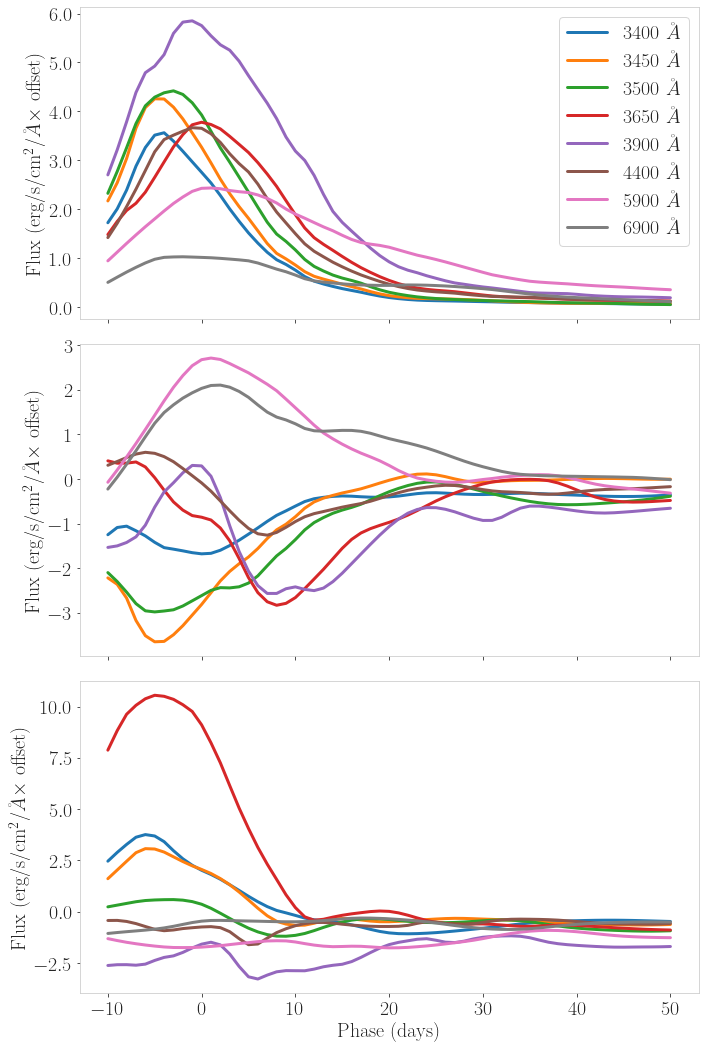

In [68]:
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)

colors=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f"]#"#fde725","#a0da39","#4ac16d","#1fa187","#277f8e","#365c8d","#46327e","#440154"]
for j,i in enumerate([0,5,10,25,50,100,250,350]):#
    axs[0].plot(X[i],M_3_quartimax[0][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax1.set_xlabel("Phase (days)")
    axs[0].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend()
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[1].plot(X[i],M_3_quartimax[1][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax2.set_xlabel("Phase (days)")
    axs[1].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[1].yaxis.set_major_formatter(formatter11)
    #axs[1].legend(loc=1)
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[2].plot(X[i],M_3_quartimax[2][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    axs[2].set_xlabel("Phase (days)")
    axs[2].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax3.set_title("Third Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[2].yaxis.set_major_formatter(formatter11)
    #axs[2].legend(loc=1)

#plt.show()
fig.tight_layout()
plt.savefig('./fa/fanz_FA_components_quartimax.pdf')  

# First, Second and Third Principal Components

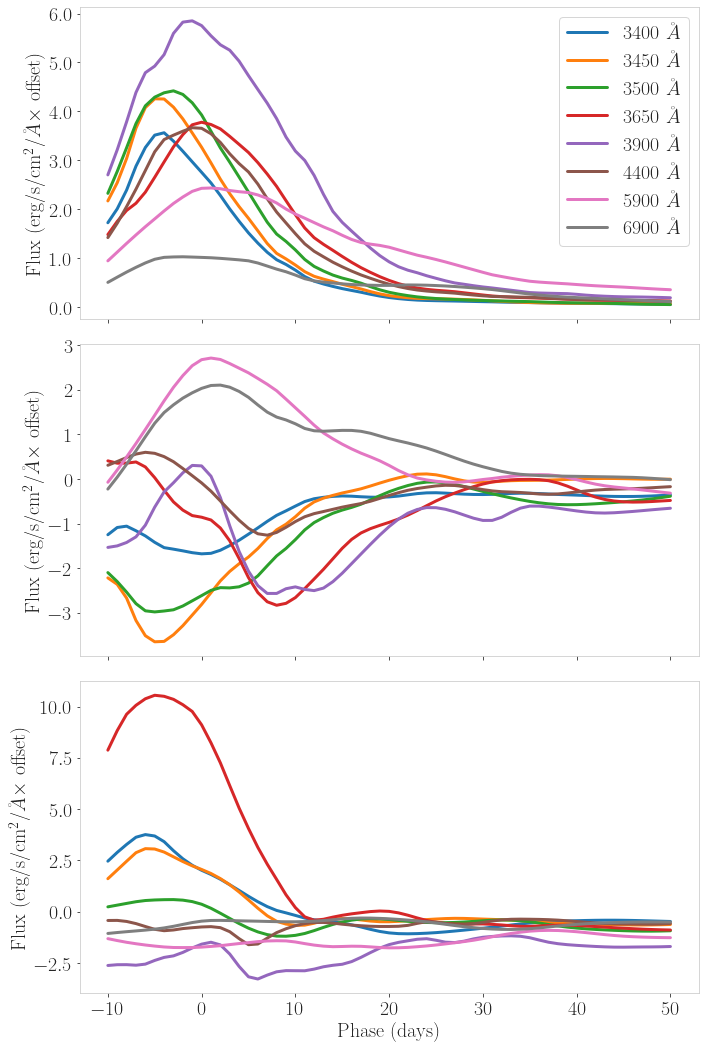

In [69]:
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)

colors=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f"]#"#fde725","#a0da39","#4ac16d","#1fa187","#277f8e","#365c8d","#46327e","#440154"]
for j,i in enumerate([0,5,10,25,50,100,250,350]):#
    axs[0].plot(X[i],M_3_equamax[0][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax1.set_xlabel("Phase (days)")
    axs[0].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend()
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[1].plot(X[i],M_3_equamax[1][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax2.set_xlabel("Phase (days)")
    axs[1].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[1].yaxis.set_major_formatter(formatter11)
    #axs[1].legend(loc=1)
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[2].plot(X[i],M_3_equamax[2][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    axs[2].set_xlabel("Phase (days)")
    axs[2].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax3.set_title("Third Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[2].yaxis.set_major_formatter(formatter11)
    #axs[2].legend(loc=1)

#plt.show()
fig.tight_layout()
plt.savefig('./fa/fanz_FA_components_equamax.pdf')  

# First, Second and Third Principal Components

## Creating synthetic photometry from test data

In [70]:
filters=["cspg","cspr","cspv9844"]

In [71]:
filters_label=["CSP-G","CSP-R","CSP-V9844"]

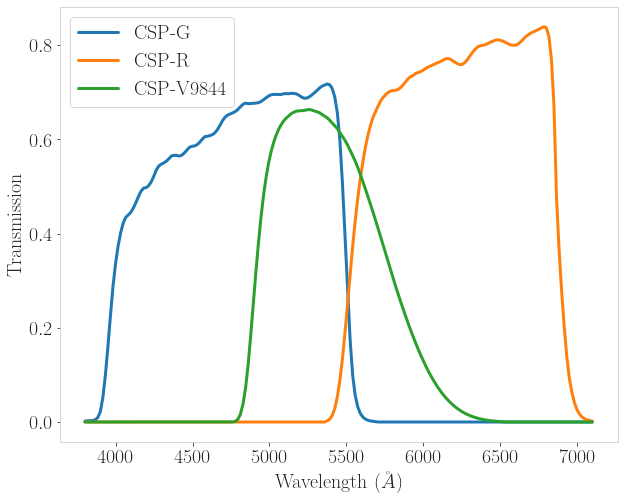

In [72]:
fig=plt.figure(figsize=(10,8))
colors=["#1f77b4","#ff7f0e","#2ca02c"]#"#fde725","#21918c","#440154"]
for j,f in enumerate(filters):
    plt.plot(np.linspace(3800,7100,200),sncosmo.get_bandpass(f)(np.linspace(3800,7100,200)),label=filters_label[j],lw=3,color=colors[j])
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Transmission")
plt.legend(loc=2)
plt.show()

In [73]:
d={}
for i in range(len(test_data)):
    d[i]=test_data[i].reshape(Y.shape)*SCALE_FACTOR

## Validating the FA

In [74]:
class EXP_LC_FA3(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2']
    param_names_latex = ['x_0', 'x_1', 'x_2']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, name='EXP', version='2022'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0.T)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1.T)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2.T)

        self._parameters = np.array([1, 0, 0])  # initial guess
        

    def _flux(self, phase, wave):
        
        x0, x1, x2= self._parameters

        return x0 *(self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave))

In [75]:
exp_fa_no_rot = EXP_LC_FA3(p_grid, w_grid2, M_3_no_rot[0]*SCALE_FACTOR, M_3_no_rot[1]*SCALE_FACTOR, M_3_no_rot[2]*SCALE_FACTOR)
exp_fa_varimax = EXP_LC_FA3(p_grid, w_grid2, M_3_varimax[0]*SCALE_FACTOR, M_3_varimax[1]*SCALE_FACTOR, M_3_varimax[2]*SCALE_FACTOR)
exp_fa_promax = EXP_LC_FA3(p_grid, w_grid2, M_3_promax[0]*SCALE_FACTOR, M_3_promax[1]*SCALE_FACTOR, M_3_promax[2]*SCALE_FACTOR)
exp_fa_oblimin = EXP_LC_FA3(p_grid, w_grid2, M_3_oblimin[0]*SCALE_FACTOR, M_3_oblimin[1]*SCALE_FACTOR, M_3_oblimin[2]*SCALE_FACTOR)
exp_fa_oblimax = EXP_LC_FA3(p_grid, w_grid2, M_3_oblimax[0]*SCALE_FACTOR, M_3_oblimax[1]*SCALE_FACTOR, M_3_oblimax[2]*SCALE_FACTOR)
exp_fa_quartimin = EXP_LC_FA3(p_grid, w_grid2, M_3_quartimin[0]*SCALE_FACTOR, M_3_quartimin[1]*SCALE_FACTOR, M_3_quartimin[2]*SCALE_FACTOR)
exp_fa_quartimax = EXP_LC_FA3(p_grid, w_grid2, M_3_quartimax[0]*SCALE_FACTOR, M_3_quartimax[1]*SCALE_FACTOR, M_3_quartimax[2]*SCALE_FACTOR)
exp_fa_equamax = EXP_LC_FA3(p_grid, w_grid2, M_3_equamax[0]*SCALE_FACTOR, M_3_equamax[1]*SCALE_FACTOR, M_3_equamax[2]*SCALE_FACTOR)

In [76]:
csp=sncosmo.get_magsystem("csp")

In [77]:
file=open("./fa/fanz_validation_fit_results.dat","w")

In [78]:
for k in range(len(d)):
    print(test_names[k])
    fig,axs=plt.subplots(3,1,figsize=(8,12),sharex=True)

    colors=["#1f77b4","#ff7f0e","#2ca02c"]#"#fde725","#21918c","#440154"]
    filt=[]
    ph=[]
    fl=[]
    flerr=[]
    for j,f in enumerate(filters):
        lc=interp1d(p_grid,np.sum(d[k]*sncosmo.get_bandpass(f)(Y)*Y*10/HC_ERG_AA,axis=0))
        np.random.seed(42)
        p_random=np.random.choice(np.linspace(-10,50,61), size=20, replace=False)
        #p_random.sort()
        np.random.seed(42)
        y_err=lc(p_random)*np.array([0.1 for i in range(20)])/10 #random.rand()

        filt.append([f]*len(p_random))
        ph.append(list(p_random))
        fl.append(list(lc(p_random)))
        flerr.append(list(y_err))
        #axs[j].errorbar(p_random,lc(p_random),yerr=y_err,label=f"Flux through {f} filter",color=colors[j],ls="none",fmt='o')

    df={"time":np.array(ph).reshape(-1),"flux":np.array(fl).reshape(-1),"fluxerr":np.array(flerr).reshape(-1),"flt":np.array(filt).reshape(-1)}
    df=pd.DataFrame(df)
    df["zpsys"]="csp"
    
    zp=[]
    for j in df["flt"]:
        zp.append(2.5*np.log10(csp.zpbandflux(j)))

    df["zp"]=zp

    dust = sncosmo.F99Dust()
    model_fa_no_rot = sncosmo.Model(source=exp_fa_no_rot)
    model_fa_no_rot.set(z=0.,t0=0.) 
    model_fa_varimax = sncosmo.Model(source=exp_fa_varimax)
    model_fa_varimax.set(z=0.,t0=0.) 
    model_fa_promax = sncosmo.Model(source=exp_fa_promax)
    model_fa_promax.set(z=0.,t0=0.) 
    model_fa_oblimin = sncosmo.Model(source=exp_fa_oblimin)
    model_fa_oblimin.set(z=0.,t0=0.) 
    model_fa_oblimax = sncosmo.Model(source=exp_fa_oblimax)
    model_fa_oblimax.set(z=0.,t0=0.) 
    model_fa_quartimin = sncosmo.Model(source=exp_fa_quartimin)
    model_fa_quartimin.set(z=0.,t0=0.) 
    model_fa_quartimax = sncosmo.Model(source=exp_fa_quartimax)
    model_fa_quartimax.set(z=0.,t0=0.) 
    model_fa_equamax = sncosmo.Model(source=exp_fa_equamax)
    model_fa_equamax.set(z=0.,t0=0.) 
    
    dat=Table.from_pandas(df)
    dat.remove_rows(np.where(dat["flux"]<0.))
    dat.remove_rows(np.where(dat["fluxerr"]<0.))

    result_fa_no_rot, fitted_model_fa_no_rot = sncosmo.fit_lc(dat, model_fa_no_rot, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(-10, 50.), wave_range=(3500.,8400.), verbose=False)
    result_fa_varimax, fitted_model_fa_varimax = sncosmo.fit_lc(dat, model_fa_varimax, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(-10, 50.), wave_range=(3500.,8400.), verbose=False)
    result_fa_promax, fitted_model_fa_promax = sncosmo.fit_lc(dat, model_fa_promax, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(-10, 50.), wave_range=(3500.,8400.), verbose=False)
    result_fa_oblimin, fitted_model_fa_oblimin = sncosmo.fit_lc(dat, model_fa_oblimin, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(-10, 50.), wave_range=(3500.,8400.), verbose=False)
    result_fa_oblimax, fitted_model_fa_oblimax = sncosmo.fit_lc(dat, model_fa_oblimax, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(-10, 50.), wave_range=(3500.,8400.), verbose=False)
    result_fa_quartimin, fitted_model_fa_quartimin = sncosmo.fit_lc(dat, model_fa_quartimin, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(-10, 50.), wave_range=(3500.,8400.), verbose=False)
    result_fa_quartimax, fitted_model_fa_quartimax = sncosmo.fit_lc(dat, model_fa_quartimax, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(-10, 50.), wave_range=(3500.,8400.), verbose=False)
    result_fa_equamax, fitted_model_fa_equamax = sncosmo.fit_lc(dat, model_fa_equamax, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(-10, 50.), wave_range=(3500.,8400.), verbose=False)

    file.write(f"{test_names[k]}:\n")
    file.write(f"EXP3(FA) no rot fit chi2/ndof={round(result_fa_no_rot.chisq/result_fa_no_rot.ndof,2)}\n")
    file.write(f"x0={round(result_fa_no_rot.parameters[2],4)} +/- {round(result_fa_no_rot.errors['x0'],4)}, x1={round(result_fa_no_rot.parameters[3],4)} +/- {round(result_fa_no_rot.errors['x1'],4)}, x2={round(result_fa_no_rot.parameters[4],4)} +/- {round(result_fa_no_rot.errors['x2'],4)}\n")
    
    file.write(f"EXP3(FA) varimax fit chi2/ndof={round(result_fa_varimax.chisq/result_fa_varimax.ndof,2)}\n")  
    file.write(f"x0={round(result_fa_varimax.parameters[2],4)} +/- {round(result_fa_varimax.errors['x0'],4)}, x1={round(result_fa_varimax.parameters[3],4)} +/- {round(result_fa_varimax.errors['x1'],4)}, x2={round(result_fa_varimax.parameters[4],4)} +/- {round(result_fa_varimax.errors['x2'],4)}\n")
    
    file.write(f"EXP3(FA) promax fit chi2/ndof={round(result_fa_promax.chisq/result_fa_promax.ndof,2)}\n")
    file.write(f"x0={round(result_fa_promax.parameters[2],4)} +/- {round(result_fa_promax.errors['x0'],4)}, x1={round(result_fa_promax.parameters[3],4)} +/- {round(result_fa_promax.errors['x1'],4)}, x2={round(result_fa_promax.parameters[4],4)} +/- {round(result_fa_promax.errors['x2'],4)}\n")

    file.write(f"EXP3(FA) oblimin fit chi2/ndof={round(result_fa_oblimin.chisq/result_fa_oblimin.ndof,2)}\n")
    file.write(f"x0={round(result_fa_oblimin.parameters[2],4)} +/- {round(result_fa_oblimin.errors['x0'],4)}, x1={round(result_fa_oblimin.parameters[3],4)} +/- {round(result_fa_oblimin.errors['x1'],4)}, x2={round(result_fa_oblimin.parameters[4],4)} +/- {round(result_fa_oblimin.errors['x2'],4)}\n")
    
    file.write(f"EXP3(FA) oblimax fit chi2/ndof={round(result_fa_oblimax.chisq/result_fa_oblimax.ndof,2)}\n")
    file.write(f"x0={round(result_fa_oblimax.parameters[2],4)} +/- {round(result_fa_oblimax.errors['x0'],4)}, x1={round(result_fa_oblimax.parameters[3],4)} +/- {round(result_fa_oblimax.errors['x1'],4)}, x2={round(result_fa_oblimax.parameters[4],4)} +/- {round(result_fa_oblimax.errors['x2'],4)}\n")
    
    file.write(f"EXP3(FA) quartimin fit chi2/ndof={round(result_fa_quartimin.chisq/result_fa_quartimin.ndof,2)}\n")
    file.write(f"x0={round(result_fa_quartimin.parameters[2],4)} +/- {round(result_fa_quartimin.errors['x0'],4)}, x1={round(result_fa_quartimin.parameters[3],4)} +/- {round(result_fa_quartimin.errors['x1'],4)}, x2={round(result_fa_quartimin.parameters[4],4)} +/- {round(result_fa_quartimin.errors['x2'],4)}\n")
    
    file.write(f"EXP3(FA) quartimax fit chi2/ndof={round(result_fa_quartimax.chisq/result_fa_quartimax.ndof,2)}\n")
    file.write(f"x0={round(result_fa_quartimax.parameters[2],4)} +/- {round(result_fa_quartimax.errors['x0'],4)}, x1={round(result_fa_quartimax.parameters[3],4)} +/- {round(result_fa_quartimax.errors['x1'],4)}, x2={round(result_fa_quartimax.parameters[4],4)} +/- {round(result_fa_quartimax.errors['x2'],4)}\n")
    
    file.write(f"EXP3(FA) equamax fit chi2/ndof={round(result_fa_equamax.chisq/result_fa_equamax.ndof,2)}\n")
    file.write(f"x0={round(result_fa_equamax.parameters[2],4)} +/- {round(result_fa_equamax.errors['x0'],4)}, x1={round(result_fa_equamax.parameters[3],4)} +/- {round(result_fa_equamax.errors['x1'],4)}, x2={round(result_fa_equamax.parameters[4],4)} +/- {round(result_fa_equamax.errors['x2'],4)}\n\n")
     
    for j,f in enumerate(filters):
        axs[j].errorbar(dat[dat["flt"]==f]["time"], dat[dat["flt"]==f]["flux"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11), yerr=dat[dat["flt"]==f]["fluxerr"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11),label=f"Synthetic photometry in {filters_label[j]}",color=colors[j],ls="none",fmt='o')
        axs[j].plot(np.linspace(-10,50,100),fitted_model_fa_no_rot.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),linewidth=3,color=colors[j])#,label=f"EXP3(FA) fit ($\chi^2/ndof$={round(result_fa.chisq/result_fa3.ndof,2)})")
        axs[j].plot(np.linspace(-10,50,100),fitted_model_fa_varimax.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),linewidth=3,color=colors[j])#,label=f"EXP3(FA) fit ($\chi^2/ndof$={round(result_fa.chisq/result_fa3.ndof,2)})")
        axs[j].plot(np.linspace(-10,50,100),fitted_model_fa_promax.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),linewidth=3,color=colors[j])#,label=f"EXP3(FA) fit ($\chi^2/ndof$={round(result_fa.chisq/result_fa3.ndof,2)})")
        axs[j].plot(np.linspace(-10,50,100),fitted_model_fa_oblimin.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),linewidth=3,color=colors[j])#,label=f"EXP3(FA) fit ($\chi^2/ndof$={round(result_fa3.chisq/result_fa3.ndof,2)})")
        axs[j].plot(np.linspace(-10,50,100),fitted_model_fa_oblimax.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),linewidth=3,color=colors[j])#,label=f"EXP3(FA) fit ($\chi^2/ndof$={round(result_fa3.chisq/result_fa3.ndof,2)})")
        axs[j].plot(np.linspace(-10,50,100),fitted_model_fa_quartimin.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),linewidth=3,color=colors[j])#,label=f"EXP3(FA) fit ($\chi^2/ndof$={round(result_fa3.chisq/result_fa3.ndof,2)})")
        axs[j].plot(np.linspace(-10,50,100),fitted_model_fa_quartimax.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),linewidth=3,color=colors[j])#,label=f"EXP3(FA) fit ($\chi^2/ndof$={round(result_fa3.chisq/result_fa3.ndof,2)})")
        axs[j].plot(np.linspace(-10,50,100),fitted_model_fa_equamax.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),linewidth=3,color=colors[j])#,label=f"EXP3(FA) fit ($\chi^2/ndof$={round(result_fa3.chisq/result_fa3.ndof,2)})")
        axs[j].set_ylabel(r"Flux $ZP_{AB}=27.5$")
        formatter11=ScalarFormatterClass1()
        formatter11.set_scientific(True)
        formatter11.set_powerlimits((0,0))
        axs[j].yaxis.set_major_formatter(formatter11)
        axs[j].legend(loc=3)
        if j==len(filters)-1:
            axs[j].set_xlabel("Phase (days)")
    #plt.show() 
    #sncosmo.plot_lc(dat,model=fitted_model_fa3,errors=result_fa3.errors,zp=27.5)
    fig.tight_layout()
    plt.savefig(f"./fa/fanz_validation_fit_FA_{test_names[k]}.pdf")  
    plt.close(fig)
file.close()

Train_SN45_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN9_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN100_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN121_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN27_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN58_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN95_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN38_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN42_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN56_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN23_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN17_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN63_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN109_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN30_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN12_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN18_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
